In [2]:
# In this notebook, we will explore the results by using a Logistic Regression model and a XGBoost model. For NLP, we will use CountVectorizer and TfidfVectorizer.

In [3]:
# Step 1: import the necessary libraries
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Optional - Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Step 2: Reading the data and preliminary analysis

In [4]:
dataframe = pd.read_csv("dataset/data.csv", on_bad_lines='skip', encoding='utf-8')
dataframe.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#Preprocessing on data

*   Dropping few columns
*   checking for nulls


Dropping subject and date columns as we don't think these contain relevant information to determine whether news is fake news or not and to prevent untrue correlations. 

In [5]:
df = dataframe.copy()
df = df.drop(columns = ["subject","date"], axis = 1)

Checking the class imbalance

In [6]:
df["label"].value_counts() #It seems classes are balanced

label
1    19999
0    19943
Name: count, dtype: int64

Checking for nulls in the dataset

In [7]:
df.isnull().sum() # there is no null value

label    0
title    0
text     0
dtype: int64

Step 3: Create a Function for all data cleaning

In [8]:
# This codeblock contains a text preprocessing pipeline that aims to preserve acronyms while cleaning the text data. However, as of yet the code does not work, so including it here for reference. 
# Download required resources (if not already done)
'''import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

def text_preprocessing_pipeline(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)

    # Step 2: Remove stopwords BUT preserve acronyms first
    stop_words = set(stopwords.words('english'))
    filtered_tokens = []
    
    for word in tokens:
        # Simple acronym detection - if it has uppercase letters or dots between letters
        is_potential_acronym = (
            bool(re.search(r'[A-Z]', word)) and len(word) >= 2 and 
            (word.isupper() or '.' in word)
        )
        
        # Keep if it's not a stopword OR if it looks like an acronym
        if is_potential_acronym or word.lower() not in stop_words:
            filtered_tokens.append(word)
    
    # Step 3: Enhanced cleaning that preserves acronyms
    cleaned_tokens = []
    
    for word in filtered_tokens:
        # Pattern 1: Common acronyms (2+ letters with dots: U.S., U.K., etc.)
        if re.match(r'^[A-Z](\.[A-Z])+\.?$', word):
            # Remove dots from acronyms and keep them
            cleaned_word = re.sub(r'\.', '', word)
            cleaned_tokens.append(cleaned_word.lower())
        
        # Pattern 2: All caps acronyms without dots (USA, NASA, FBI, etc.)
        elif re.match(r'^[A-Z]{2,}$', word):
            cleaned_tokens.append(word.lower())
        
        # Pattern 3: Mixed case acronyms/abbreviations (PhD, CEO, etc.)
        elif re.match(r'^[A-Za-z]{2,}$', word) and any(c.isupper() for c in word[1:]):
            cleaned_tokens.append(word.lower())
        
        # Pattern 4: Regular words - remove punctuation and numbers
        else:
            # Keep only letters
            cleaned_word = re.sub(r'[^a-zA-Z]', '', word.lower())
            if cleaned_word:  # Only add non-empty strings
                cleaned_tokens.append(cleaned_word)
    
    # Step 4: Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in cleaned_tokens]

    return ' '.join(lemmatized_tokens)



test_text = "U.S. military to accept transgender recruits"
result = text_preprocessing_pipeline(test_text)
print(f"Test result: '{result}'")'''

'import re\nimport string\nimport nltk\nfrom nltk.tokenize import word_tokenize\nfrom nltk.corpus import stopwords\nfrom nltk.stem import WordNetLemmatizer\nnltk.download(\'punkt\')\nnltk.download(\'stopwords\')\nnltk.download(\'wordnet\')\n# Download the \'punkt_tab\' resource\nnltk.download(\'punkt_tab\')\n\ndef text_preprocessing_pipeline(text):\n    # Step 1: Tokenize the text\n    tokens = word_tokenize(text)\n\n    # Step 2: Remove stopwords BUT preserve acronyms first\n    stop_words = set(stopwords.words(\'english\'))\n    filtered_tokens = []\n\n    for word in tokens:\n        # Simple acronym detection - if it has uppercase letters or dots between letters\n        is_potential_acronym = (\n            bool(re.search(r\'[A-Z]\', word)) and len(word) >= 2 and \n            (word.isupper() or \'.\' in word)\n        )\n\n        # Keep if it\'s not a stopword OR if it looks like an acronym\n        if is_potential_acronym or word.lower() not in stop_words:\n            filtered

In [9]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')


def text_preprocessing_pipeline(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)

    # Step 2: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

    # Step 3: Remove punctuation and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens]  # Keep only letters
    tokens = [word for word in tokens if word]  # Remove empty strings

    # Step 4: Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
df['clean_text'] = df['text'].apply(text_preprocessing_pipeline)
df['clean_title'] = df['title'].apply(text_preprocessing_pipeline)



In [11]:
# Create a new DataFrame with the cleaned text and cleaned titles
cleaned_df = pd.DataFrame({
    'clean_text': df['clean_text'],
    'clean_title': df['clean_title'],
    'label': df['label']
})

print(cleaned_df.head())
print(cleaned_df.shape)

                                          clean_text  \
0  washington reuters head conservative republica...   
1  washington reuters transgender people allowed ...   
2  washington reuters special counsel investigati...   
3  washington reuters trump campaign adviser geor...   
4  seattlewashington reuters president donald tru...   

                                         clean_title  label  
0  u budget fight loom republican flip fiscal script      1  
1  u military accept transgender recruit monday p...      1  
2     senior u republican senator let mr mueller job      1  
3  fbi russia probe helped australian diplomat ti...      1  
4  trump want postal service charge much amazon s...      1  
(39942, 3)


# Train Test Split

In [12]:
#Model 1: CountVectorizer + Losistic Regression
#When we train the model on two columns, a difficulty that arises is that CountVectorizer does not automatically concatenate the two columns as we would want it to. 
# This causes shape mismatches. The solution we implemented is to concatenate the two columns. 

In [13]:
X = cleaned_df['clean_text'] + ' ' + cleaned_df[ 'clean_title']  # Features: cleaned text and title, concatenated text and title columns
y = cleaned_df['label']  # 'fake' or 'real'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model 1: CountVectorizer + Logistic Regression

In [14]:
# Use CounVectorizer to convert text data into a matrix of token counts
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [15]:
# Train and evaluate Logistic regression model with CountVectorizer
LG = LogisticRegression()
LG.fit(X_train_cv, y_train)
pred1 = LG.predict(X_test_cv)

print("Model 1 Accuracy:", accuracy_score(y_test, pred1))

Model 1 Accuracy: 0.9959944924270873


In [16]:
confusion_matrix(y_test, pred1)

array([[3979,   17],
       [  15, 3978]])

In [19]:
LG.score(X_test_cv, y_test)

0.9959944924270873

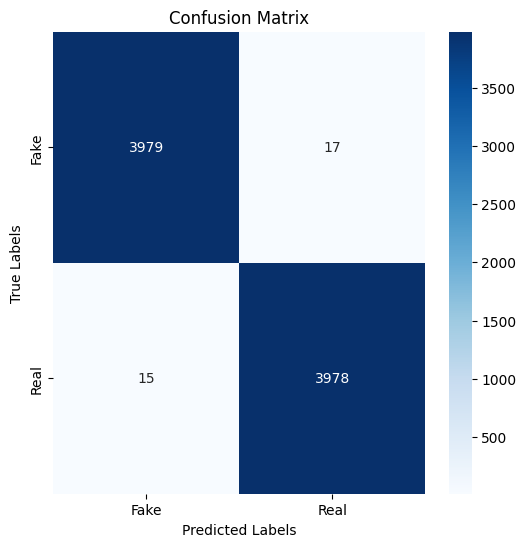

In [20]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred1), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()

#Model2 TF-IDF + Logistic Regression

In [21]:
# Use TfidfVectorizer to convert text data into a matrix of TF-IDF features
TfidfVectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = TfidfVectorizer.fit_transform(X_train)
X_test_tfidf = TfidfVectorizer.transform(X_test)

In [22]:
# Train and evalaute Logistic Regression model with TfidfVectorizer
LG2 = LogisticRegression()
LG2.fit(X_train_tfidf, y_train)
pred2 = LG2.predict(X_test_tfidf)
print("Model 2 Accuracy:", accuracy_score(y_test, pred2))

Model 2 Accuracy: 0.9872324446113406


In [23]:
confusion_matrix(y_test, pred2)

array([[3935,   61],
       [  41, 3952]])

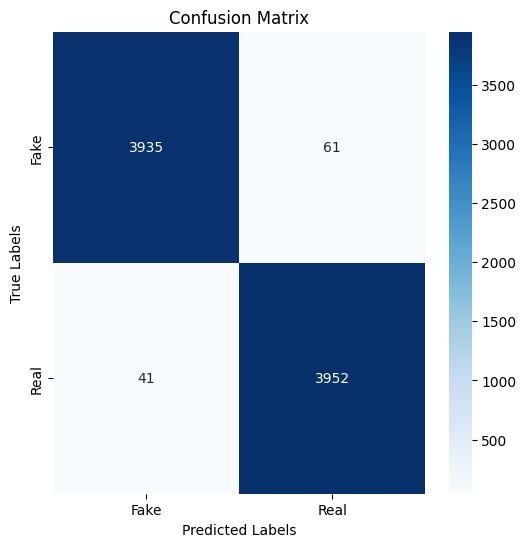

In [24]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred2), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()



#Model_3 CountVectorizer + XGBoost

In [25]:
# Train and evaluate XGBoost model with CountVectorizer
XGBmodel1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBmodel1.fit(X_train_cv, y_train)
pred3 = XGBmodel1.predict(X_test_cv)
print("XGBoost Model 3 Accuracy:", accuracy_score(y_test, pred3))




C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:40:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model 3 Accuracy: 0.9963700087620478


In [27]:
confusion_matrix(y_test, pred3)


array([[3979,   17],
       [  12, 3981]])

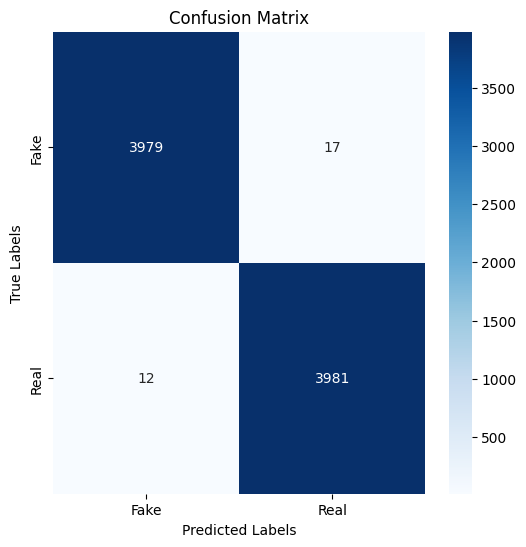

In [28]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred3), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()


C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:19:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model 4 Accuracy: 0.9958693203154337


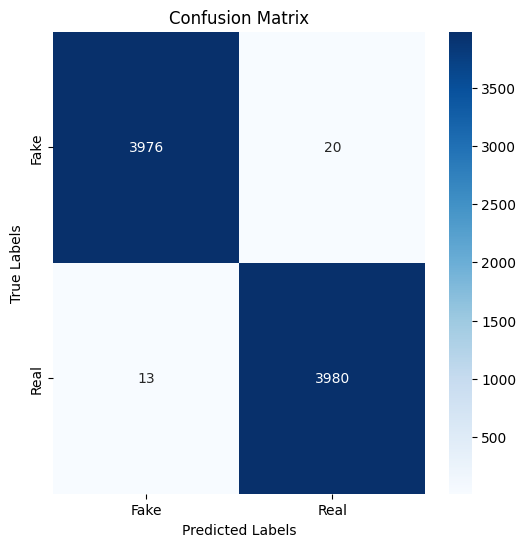

In [29]:
#Model 4: XGBoost with TfidfVectorizer
XGBmodel2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBmodel2.fit(X_train_tfidf, y_train)
pred4 = XGBmodel2.predict(X_test_tfidf)
print("XGBoost Model 4 Accuracy:", accuracy_score(y_test, pred4))
confusion_matrix(y_test, pred4)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred4), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()


In [30]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test contains integer labels (0 and 1)
# Map integer labels to string labels for classification report
target_names = ['fake', 'real']

# Generate classification reports with target_names
report1 = classification_report(y_test, pred1, target_names=target_names, output_dict=True, zero_division=0)
report2 = classification_report(y_test, pred2, target_names=target_names, output_dict=True, zero_division=0)
report3 = classification_report(y_test, pred3, target_names=target_names, output_dict=True, zero_division=0)
report4 = classification_report(y_test, pred4, target_names=target_names, output_dict=True, zero_division=0)

# Extract metrics for the table
model_comparison = {
    'Model': ['CV + LogReg', 'TF-IDF + LogReg', 'CV + XGBoost', 'TF-IDF + XGBoost'],
    'Accuracy': [accuracy_score(y_test, pred1), accuracy_score(y_test, pred2), accuracy_score(y_test, pred3), accuracy_score(y_test, pred4)],
    'Fake_Precision': [report1['fake']['precision'], report2['fake']['precision'], report3['fake']['precision'], report4['fake']['precision']],
    'Fake_Recall': [report1['fake']['recall'], report2['fake']['recall'], report3['fake']['recall'], report4['fake']['recall']],
    'Fake_F1-score': [report1['fake']['f1-score'], report2['fake']['f1-score'], report3['fake']['f1-score'], report4['fake']['f1-score']],
    'Real_Precision': [report1['real']['precision'], report2['real']['precision'], report3['real']['precision'], report4['real']['precision']],
    'Real_Recall': [report1['real']['recall'], report2['real']['recall'], report3['real']['recall'], report4['real']['recall']],
    'Real_F1-score': [report1['real']['f1-score'], report2['real']['f1-score'], report3['real']['f1-score'], report4['real']['f1-score']],
}

comparison_df = pd.DataFrame(model_comparison)
comparison_df_sorted = comparison_df.sort_values(by='Accuracy', ascending=False)
display(comparison_df_sorted)



,Model,Accuracy,Fake_Precision,Fake_Recall,Fake_F1-score,Real_Precision,Real_Recall,Real_F1-score
2,CV + XGBoost,0.996370,0.996993,0.995746,0.996369,0.995748,0.996995,0.996371
0,CV + LogReg,0.995994,0.996244,0.995746,0.995995,0.995745,0.996243,0.995994
3,TF-IDF + XGBoost,0.995869,0.996741,0.994995,0.995867,0.995000,0.996744,0.995871
1,TF-IDF + LogReg,0.987232,0.989688,0.984735,0.987205,0.984799,0.989732,0.987260


In [ ]:
# For CountVectorizer + Logistic Regression
results = grid.cv_results_
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
params = results['params']

alpha_values = [p['alpha'] for p in params]

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, train_scores, label='Training Accuracy', marker='o')
plt.plot(alpha_values, val_scores, label='Validation Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Smoothing Parameter)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha (CountVectorizer + Naive Bayes)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.show()

# For CountVectorizer + Logistic Regression
# Calculate training accuracy
y_train_pred_rf = LG.predict(X_train_tfidf)
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)

# Calculate validation accuracy (already have this as acc_rf)
val_acc_rf = acc_rf

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_rf, val_acc_rf], color=['blue', 'green'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Random Forest)')
plt.show()

# For TF-IDF + Naive Bayes
# Calculate training accuracy
y_train_pred_nb_tf = nb1_model_tf.predict(X_train_tfidf)
train_acc_nb_tf = accuracy_score(y_train, y_train_pred_nb_tf)

# Calculate validation accuracy (already have this as accuracy_score(y_test, pred1_tf))
val_acc_nb_tf = accuracy_score(y_test, pred1_tf)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_nb_tf, val_acc_nb_tf], color=['blue', 'green'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Naive Bayes)')
plt.show()